In [2]:
from __future__ import annotations
from pathlib import Path
import json, re
import numpy as np
import matplotlib.pyplot as plt

# Manually list run folders you want to plot (timestamp dirs)
RUN_DIRS = [
    # Path(
    #     "../results/bvcbm/npe/ds_pancreatic-p0-T_19-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251007-194622"
    # ),
    Path(
        "../results/bvcbm/npe/ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251008-141309"
    ),
    Path(
        "../results/bvcbm/pnpe/ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251008-141443"
    ),
    Path(
        "../results/bvcbm/prnpe/ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251009-143310"
    ),
    Path(
        "../results/bvcbm/rf_abc_npe/ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251008-142124"
    ),
    Path(
        "../results/bvcbm/rf_abc_pnpe/ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251009-144041"
    ),
    Path(
        "../results/bvcbm/rnpe/ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251009-143517"
    ),
    # Path(
    #     "../results/bvcbm/npe/ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251007-201033"
    # ),
    # Path(
    #     "../results/bvcbm/npe/ds_pancreatic-p3-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251007-201034"
    # ),
    # Path(
    #     "../results/bvcbm/prnpe/ds_pancreatic-p3-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000/seed-0/20251007-201034"
    # ),
    # Add more here...
]

In [3]:
Q = (0.025, 0.5, 0.975)  # central 90% interval + median
SAVE = True  # set True to save PNGs next to each run

In [4]:
def _infer_labels(run_dir: Path) -> tuple[str, str]:
    """Return (method, group_tag) from the results path."""
    # .../results/bvcbm/<method>/<group>/seed-*/<timestamp>
    parts = run_dir.parts
    method = parts[parts.index("bvcbm") + 1] if "bvcbm" in parts else "unknown"
    group = (
        parts[parts.index(method) + 1]
        if method in parts
        else run_dir.parent.parent.name
    )
    return method, group


def _summary_axis_label(run_dir: Path) -> str:
    ep = run_dir / "entrypoints.json"
    if ep.exists():
        s_path = json.loads(ep.read_text()).get("summaries", "")
        if s_path.endswith("summary_log"):
            return "log(volume)"
    # Fallback to group tag
    if "-sum_log-" in run_dir.as_posix():
        return "log(volume)"
    return "volume"


def load_ppd_run(run_dir: Path) -> dict:
    """Load PPD matrix, observed series, and metadata from a run folder."""
    # Prefer PPD in summary space for comparability with s_obs
    ppd_file = run_dir / "ppd_S.npy"
    if not ppd_file.exists():
        ppd_file = run_dir / "ppd_y.npy"
    Y = np.load(ppd_file)  # shape (M, T)
    s_obs = np.load(run_dir / "s_obs.npy")  # shape (T,)
    assert (
        Y.ndim == 2 and s_obs.ndim == 1 and Y.shape[1] == s_obs.size
    ), "shape mismatch"
    qs = np.quantile(Y, q=Q, axis=0)  # shape (3, T)
    method, group = _infer_labels(run_dir)
    label_y = _summary_axis_label(run_dir)
    info = {
        "method": method,
        "group": group,
        "M": Y.shape[0],
        "T": Y.shape[1],
        "y_label": label_y,
    }
    return {"qs": qs, "s_obs": s_obs, "info": info}


def load_quants(run_dir: Path) -> dict:
    quant_file = run_dir / "ppd_quants.npz"
    quants = np.load(quant_file)
    print(quants["q50"].shape)


def plot_ppd(ax, data: dict) -> None:
    qlo, qmed, qhi = np.log(data["qs"])
    s_obs = np.log(data["s_obs"])
    t = np.arange(s_obs.size)
    ax.fill_between(t, qlo, qhi, alpha=0.25, label=f"PPD {int((Q[2]-Q[0])*100)}% CI")
    ax.plot(t, qmed, linewidth=2, label="PPD median")
    ax.plot(t, s_obs, linestyle="--", marker="o", linewidth=2, label="Observed")
    info = data["info"]
    ax.set_title(f"{info['method']} | {info['group']} | M={info['M']}")
    ax.set_xlabel("day")
    ax.set_ylabel(info["y_label"])
    ax.legend(loc="best")

In [5]:
for run in RUN_DIRS:
    load_quants(run)

(32,)
(32,)
(32,)
(32,)
(32,)
(32,)


saved figures/ppd_plot_3_method1.pdf


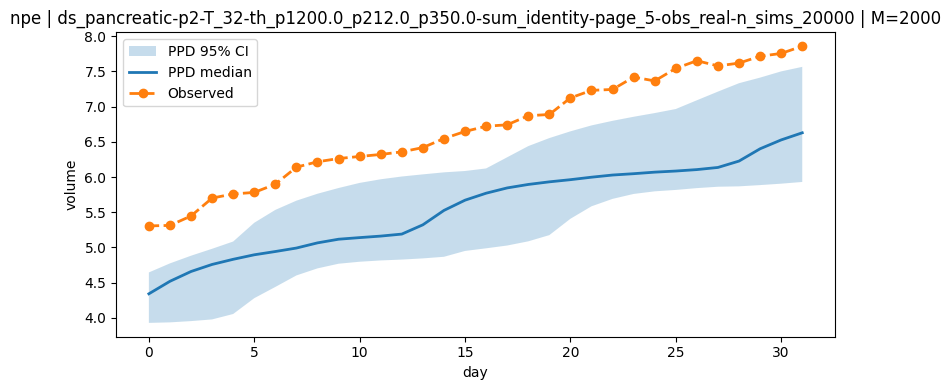

saved figures/ppd_plot_3_method2.pdf


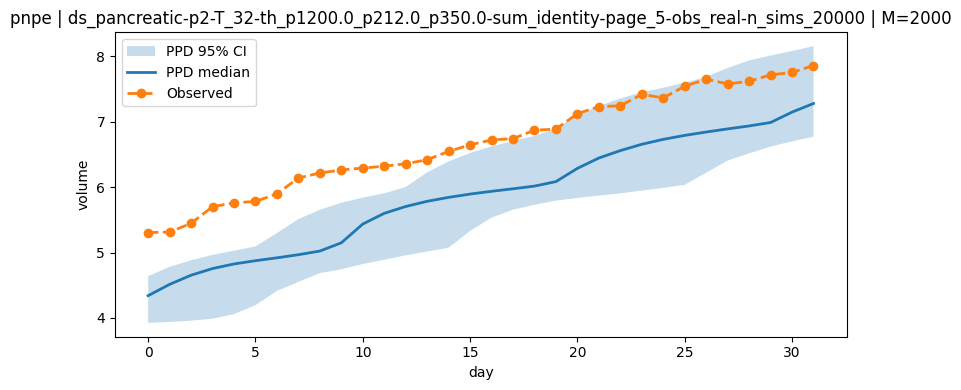

saved figures/ppd_plot_3_method3.pdf


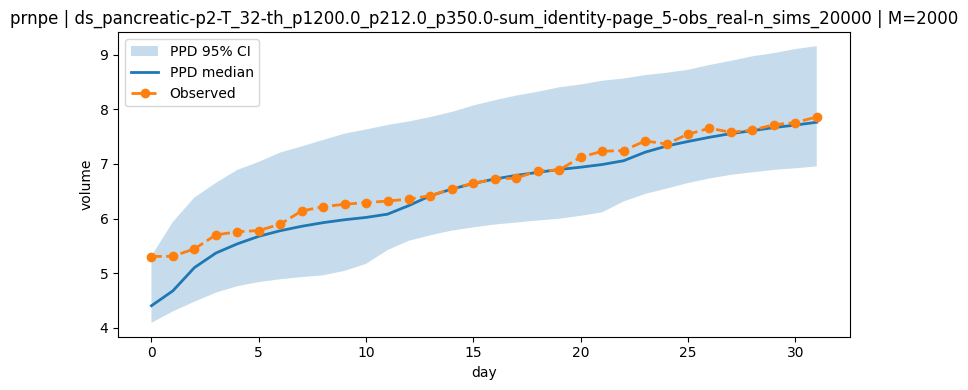

saved figures/ppd_plot_3_method4.pdf


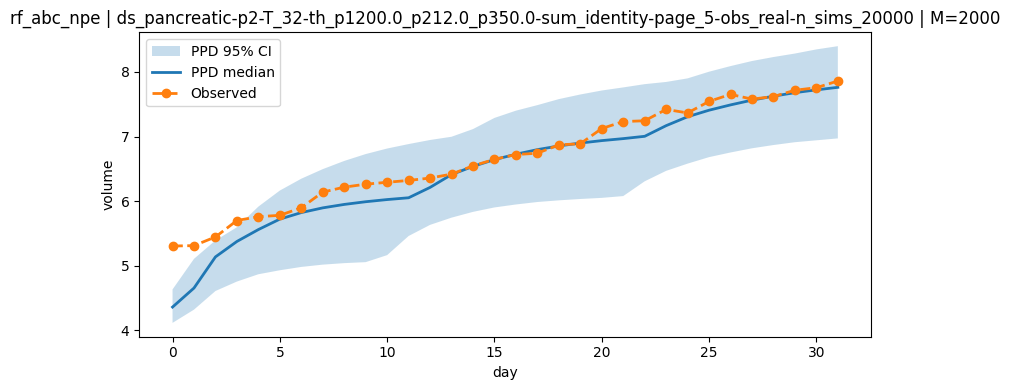

saved figures/ppd_plot_3_method5.pdf


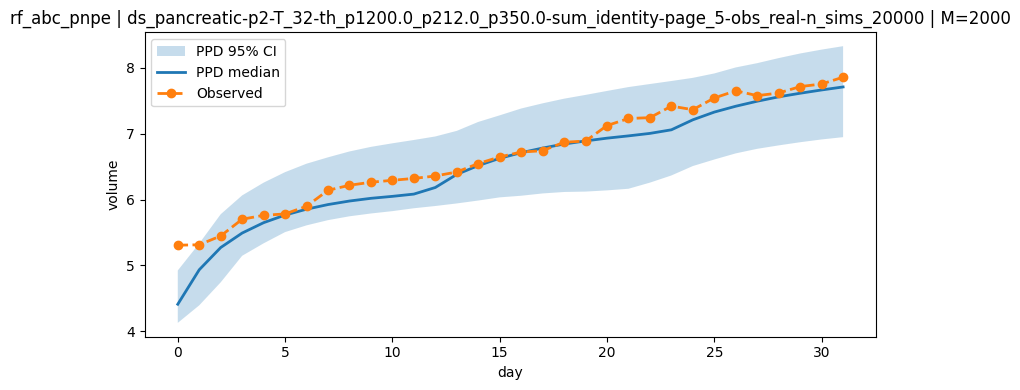

saved figures/ppd_plot_3_method6.pdf


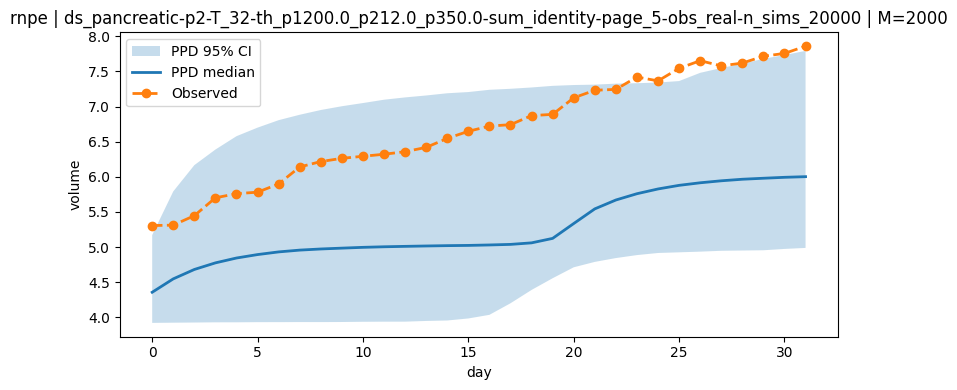

In [9]:
i = 0
for run in RUN_DIRS:
    i += 1
    d = load_ppd_run(run)
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_ppd(ax, d)
    fig.tight_layout()
    patient_id = 3
    if SAVE:
        out_png = f"figures/ppd_plot_{str(patient_id)}_method{str(i)}.pdf"
        fig.savefig(out_png, dpi=150)
        print(f"saved {out_png}")
    plt.show()

In [ ]:
for run in RUN_DIRS:
    d = load_ppd_run(run)
    qlo, _, qhi = d["qs"]
    s = d["s_obs"]
    cover = np.mean((s >= qlo) & (s <= qhi))
    print(f"{d['info']['method']} | {d['info']['group']}: coverage={cover:.2%}")
    # npe, pnpe, prnpe, rfnpe, rfpnpe, rnpe

npe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: coverage=0.00%
pnpe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: coverage=37.50%
prnpe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: coverage=100.00%
rf_abc_npe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: coverage=87.50%
rf_abc_pnpe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: coverage=96.88%
rnpe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: coverage=68.75%


npe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: median PPD distance = 1.147 [5–95% 0.6694, 1.484] | PPD-median-curve distance = 1.141 | metric=rmse space=log M=2000 T=32
pnpe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: median PPD distance = 0.8333 [5–95% 0.4849, 1.224] | PPD-median-curve distance = 0.8235 | metric=rmse space=log M=2000 T=32
prnpe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: median PPD distance = 0.3977 [5–95% 0.226, 1.09] | PPD-median-curve distance = 0.2582 | metric=rmse space=log M=2000 T=32
rf_abc_npe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: median PPD distance = 0.3515 [5–95% 0.2204, 0.8509] | PPD-median-curve distance = 0.264 | metric=rmse space=log M=2000 T=32
rf_abc_pnpe | ds_pancreatic-p2-T_32-th_p1200.0_p212.0_p350.0-sum_identity-page_5-obs_real-n_sims_20000: median PPD

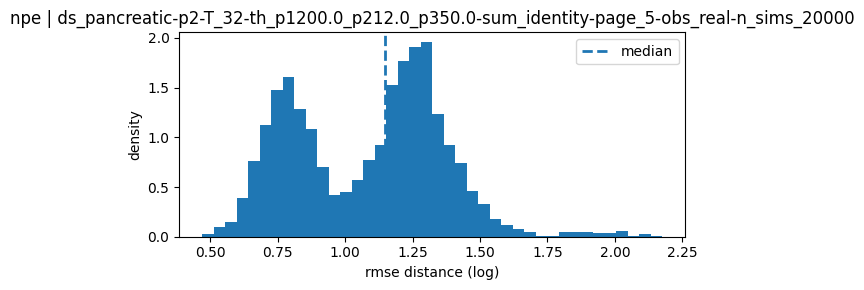

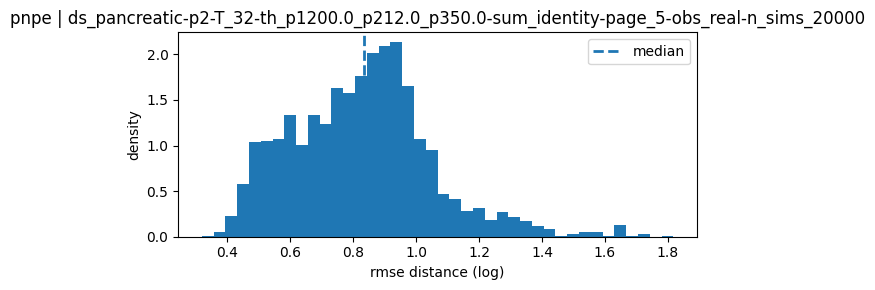

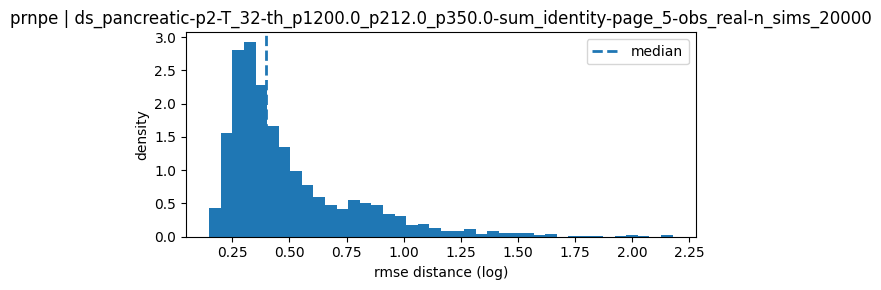

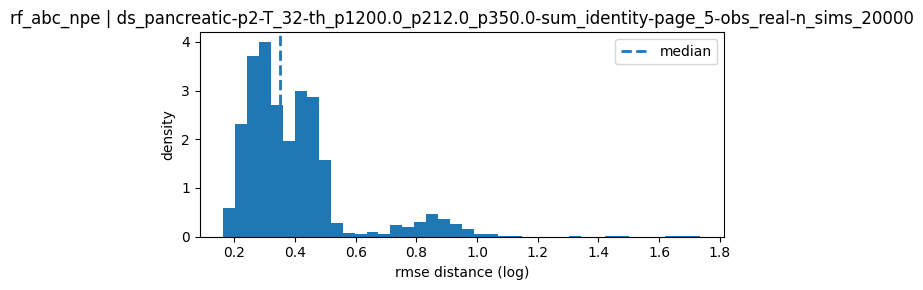

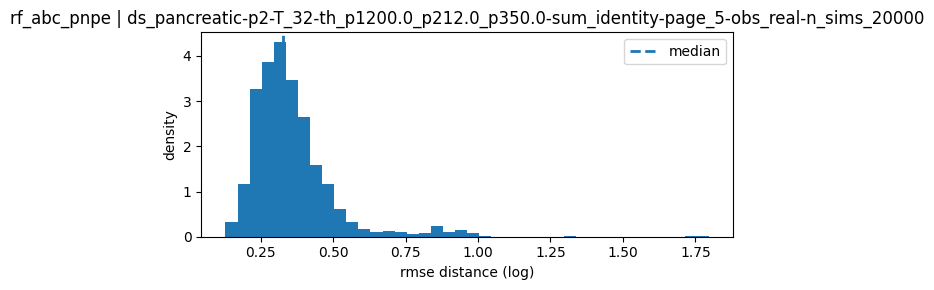

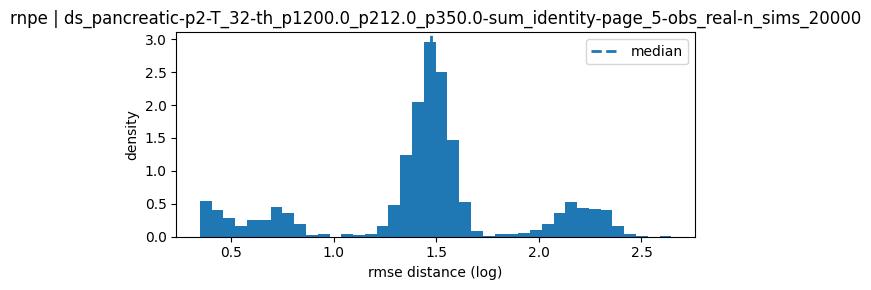

In [ ]:
from typing import Literal


def _load_Y_s_obs(run_dir: Path) -> tuple[np.ndarray, np.ndarray, dict]:
    ppd_file = run_dir / "ppd_S.npy"
    if not ppd_file.exists():
        ppd_file = run_dir / "ppd_y.npy"
    Y = np.load(ppd_file)  # (M, T)
    s_obs = np.load(run_dir / "s_obs.npy")  # (T,)
    assert Y.ndim == 2 and s_obs.ndim == 1 and Y.shape[1] == s_obs.size
    method, group = _infer_labels(run_dir)
    info = {
        "method": method,
        "group": group,
        "M": Y.shape[0],
        "T": Y.shape[1],
        "y_label": _summary_axis_label(run_dir),
    }
    return Y, s_obs, info


def _agg_dist(
    D: np.ndarray, metric: Literal["rmse", "mae", "l2"], w: np.ndarray | None
) -> np.ndarray:
    if metric == "rmse":
        return np.sqrt(np.average(D**2, axis=-1, weights=w))
    if metric == "mae":
        return np.average(np.abs(D), axis=-1, weights=w)
    if metric == "l2":
        if w is None:
            return np.linalg.norm(D, axis=-1)
        return np.sqrt(np.sum((D**2) * w, axis=-1))
    raise ValueError("unknown metric")


def ppd_distances(
    run_dir: Path,
    *,
    metric: Literal["rmse", "mae", "l2"] = "rmse",
    log: Literal["auto", "yes", "no"] = "auto",
    weights: np.ndarray | None = None,
    eps: float = 1e-12,
) -> dict:
    Y, s_obs, info = _load_Y_s_obs(run_dir)
    if weights is not None:
        weights = np.asarray(weights, float)
        assert weights.shape == s_obs.shape and np.all(weights >= 0)
        w = weights / weights.sum()
    else:
        w = None
    use_log = (log == "yes") or (log == "auto" and "log" in info["y_label"])
    if use_log:
        Y = np.log(np.clip(Y, eps, None))
        s_obs = np.log(np.clip(s_obs, eps, None))
    D = Y - s_obs  # (M, T)
    d = _agg_dist(D, metric, w)  # per-draw distances, shape (M,)
    # distance of the PPD median trajectory for reference
    y_med = np.median(Y, axis=0)
    d_medcurve = float(_agg_dist(y_med - s_obs, metric, w))
    stats = {
        "p05": float(np.quantile(d, 0.05)),
        "p50": float(np.quantile(d, 0.50)),
        "p95": float(np.quantile(d, 0.95)),
        "mean": float(d.mean()),
        "d_medcurve": d_medcurve,
    }
    return {
        "dists": d,
        "stats": stats,
        "info": info,
        "metric": metric,
        "space": "log" if use_log else "raw",
    }


# %%
# Report median posterior predictive distance per run
for run in RUN_DIRS:
    res = ppd_distances(run, metric="rmse", log="yes")
    i, s = res["info"], res["stats"]
    print(
        f"{i['method']} | {i['group']}: "
        f"median PPD distance = {s['p50']:.4g} "
        f"[5–95% {s['p05']:.4g}, {s['p95']:.4g}] | "
        f"PPD-median-curve distance = {s['d_medcurve']:.4g} | "
        f"metric={res['metric']} space={res['space']} M={i['M']} T={i['T']}"
    )

# %%
# Optional: histogram per run
for run in RUN_DIRS:
    res = ppd_distances(run, metric="rmse", log="yes")
    d, i, s = res["dists"], res["info"], res["stats"]
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.hist(d, bins=40, density=True)
    ax.axvline(s["p50"], linestyle="--", linewidth=2, label="median")
    ax.set_title(f"{i['method']} | {i['group']}")
    ax.set_xlabel(f"{res['metric']} distance ({res['space']})")
    ax.set_ylabel("density")
    ax.legend()
    fig.tight_layout()
    if SAVE:
        fig.savefig(run / "ppd_distance_hist.png", dpi=150)
    plt.show()
    # npe, pnpe, prnpe, rfnpe, rfpnpe, rnpe